## Micrograd from Scratch

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

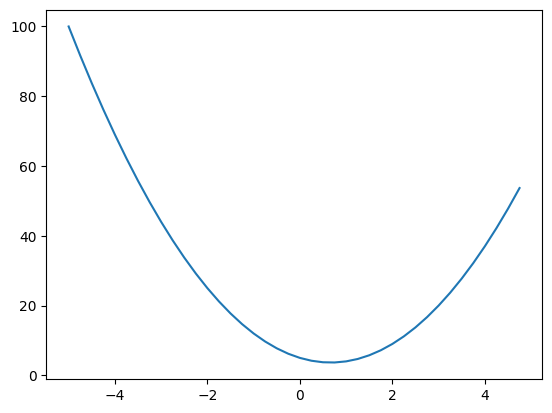

In [5]:
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.000001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# derivative wrt a
a += h
d2_a = a*b + c
print((d2_a - d1) / h)
a -= h

# derivative wrt b
b += h
d2_b = a*b + c
print((d2_b - d1) / h)
b -= h

# derivative wrt c
c += h
d2_c = a*b + c
print((d2_c - d1) / h)
c -= h

-3.000000000419334
2.000000000279556
0.9999999992515995


### Scalar autograd - defining the Value class

In [60]:
class Value:
    def __init__(self, data, _children=(), _op='', label='', requires_grad=True):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.requires_grad = requires_grad
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other), requires_grad=False)
        out = Value(self.data + other.data, (self, other), '+')
        out.label = f"{self.label} + {other.label}"

        def _backward():
            if self.requires_grad:
                self.grad += 1.0 * out.grad
            if other.requires_grad:
                other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other), requires_grad=False)
        out = Value(self.data - other.data, (self, other), '-')
        out.label = f"{self.label} - {other.label}"

        def _backward():
            if self.requires_grad:
                self.grad += 1.0 * out.grad
            if other.requires_grad:
                other.grad -= 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __rsub__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other), requires_grad=False)
        return other - self

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other), requires_grad=False)
        out = Value(self.data * other.data, (self, other), '*')

        def _make_mult_label(x, y):
            x_label = x.label
            y_label = y.label
            if x._prev and " " in x_label:
                x_label = f"({x_label})"
            if y._prev and " " in y_label:
                y_label = f"({y_label})"
            return f"{x_label} * {y_label}"
        
        out.label = _make_mult_label(self, other)

        def _backward():
            if self.requires_grad:
                self.grad += other.data * out.grad
            if other.requires_grad:
                other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other), requires_grad=False)
        out = Value(self.data / other.data, (self, other), '/')
        out.label = f"{self.label} / {other.label}"

        def _backward():
            if self.requires_grad:
                self.grad += out.grad / other.data
            if other.requires_grad:
                other.grad -= self.data * out.grad / (other.data)**2

        out._backward = _backward
        return out

    def __rtruediv__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other), requires_grad=False)
        return other / self
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        out.label = f'({self.label})**{other}'
        
        def _backward():
            if self.requires_grad:
                self.grad = other * self.data**(other - 1) * out.grad
        
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        out.label = f"tanh({self.label})"

        def _backward():
            if self.requires_grad:
                self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        out.label = f"exp({self.label})"

        def _backward():
            if self.requires_grad:
                self.grad = out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        seen = set()
        topo = list()
    
        def _topo(root):
            seen.add(root)
            for node in root._prev:
                if node not in seen:
                    _topo(node)
            topo.append(root)
        _topo(self)

        self.grad = 1   # Assuming this is the node we want grads wrt
        for node in reversed(topo):
            node._backward()

In [5]:
# Graph visualization functions
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=(uid + n._op), label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

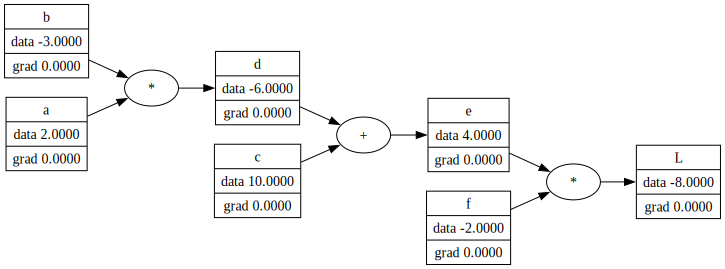

In [81]:
# Visualize the forward pass
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label = 'd'
e = c + d; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'
draw_dot(L)

### Back-propagating on a single neuron with 2 inputs

In [83]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# sum
x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b; n.label = 'n'

# activation
o = n.tanh(); o.label = 'o'

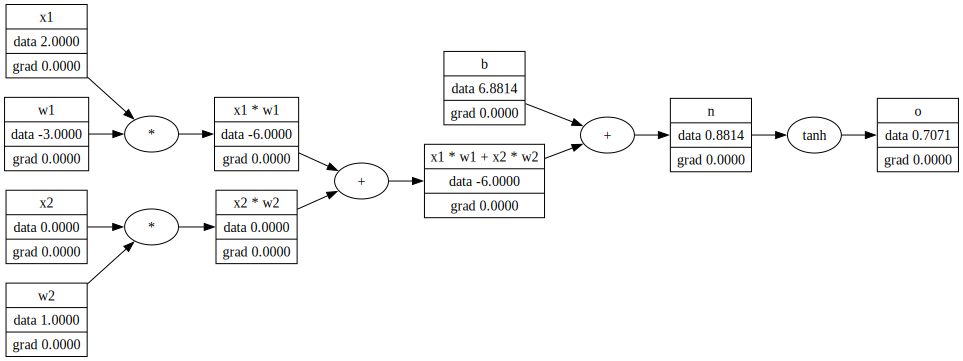

In [84]:
# Draw forward pass
draw_dot(o)

In [44]:
# Calling _backward in the right order
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

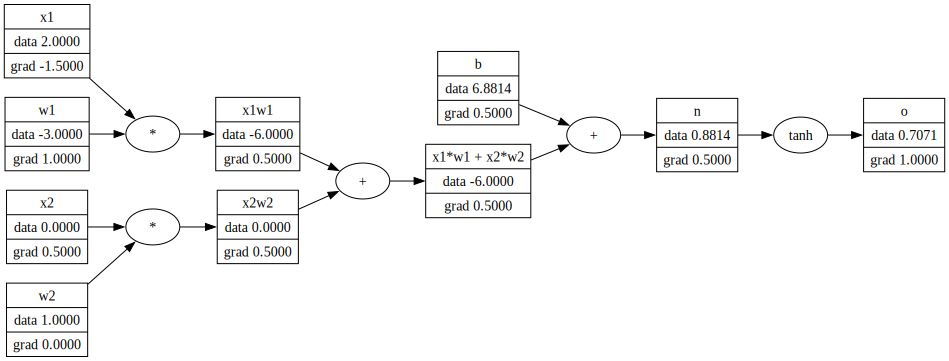

In [45]:
# We can now look at all the grads
draw_dot(o)

In [51]:
# topo sort function to help call _backward automatically in the right order
def get_topo(root):
    topo = list()
    
    def _topo(root):
        for node in root._prev:
            _topo(node)
        topo.append(root)
    _topo(root)
    return topo

In [52]:
topo_order = get_topo(o)
topo_order

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

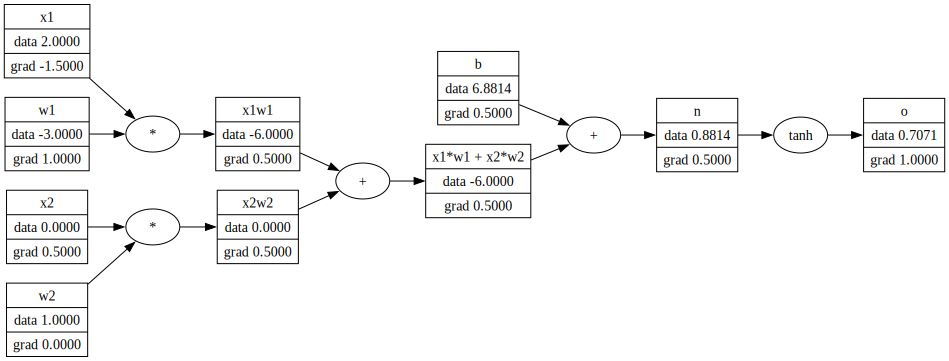

In [ ]:
o.grad = 1
for node in reversed(topo_order):
    node._backward()

draw_dot(o)

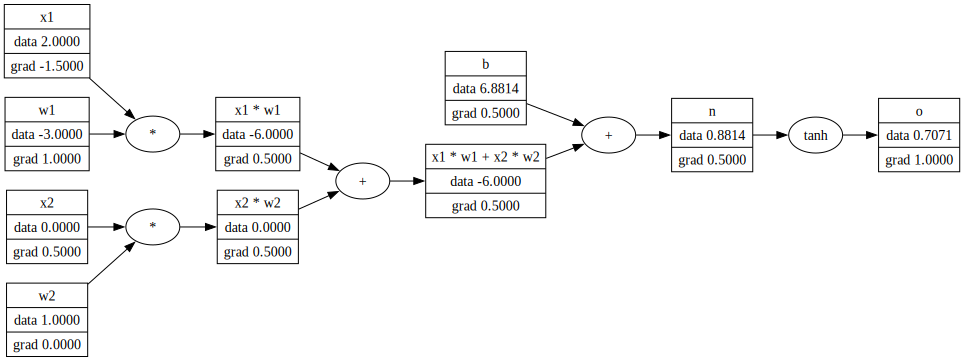

In [85]:
# Now using the backward() method:
o.backward()
draw_dot(o)

### Corner case: What if the same var is used twice in an expression/node?

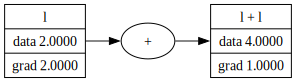

In [ ]:
l = Value(2.0, label='l')
m = l + l; m.label = 'm'

m.backward()
draw_dot(m)

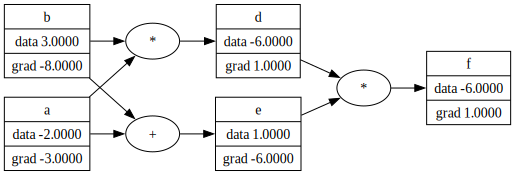

In [78]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b   ; d.label = 'd'
e = a + b   ; e.label = 'e'
f = d * e   ; f.label = 'f'

f.backward()
draw_dot(f)

### Single neuron example with more operators

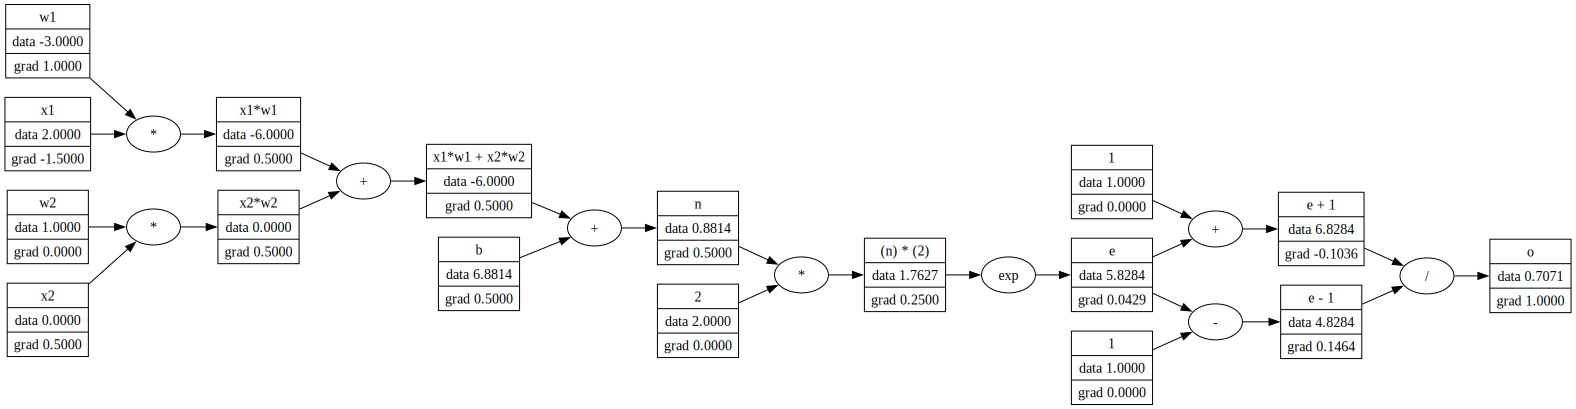

In [6]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# sum
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b; n.label = 'n'

# activation
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)
# o = n.tanh(); o.label = 'o'

In [93]:
a = Value(2.0)
b = Value(3.0)
a / b

Value(data=0.6666666666666666)

### Neural Network Class

In [85]:
class Neuron:

    def __init__(self, nin, layer_label=""):
        self.weights = [Value(np.random.uniform(-1, 1), label=f"{layer_label}w{i}") for i in range(nin)]
        self.bias = Value(np.random.uniform(-1, 1), label=f"{layer_label}b")

    def __call__(self, x):
        s = sum([xi * wi for xi, wi in zip(x, self.weights)], self.bias)
        o = s.tanh()
        o.label = 'o'
        return o

    def parameters(self):
        return self.weights + [self.bias]


class Layer:

    def __init__(self, nin, nout, label=""):
        self.label = label
        self.neurons = [Neuron(nin, layer_label=label) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        for i, o in enumerate(outs):
            o.label = f"{self.label}o{i}"
        return outs if len(outs) > 1 else outs[0]

    def parameters(self):
        return sum([n.parameters() for n in self.neurons], [])

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], label=f"l{i}") for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return sum([l.parameters() for l in self.layers], [])

### Testing Neuron and Layer classes

In [36]:
n = Neuron(2)
neuron_output = n([-2.0, 3])
neuron_output.backward()
print(neuron_output)

Value(data=0.9781414343215926)


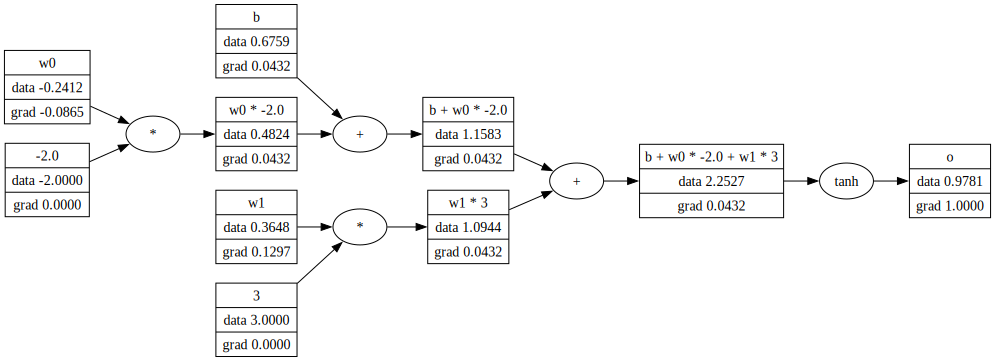

In [37]:
draw_dot(neuron_output)

In [38]:
layer = Layer(5, 2)
outs = layer([2.0, -3.0, 1.0, 1.5, -4.5])
outs

[Value(data=-0.9852608303449991), Value(data=-0.08944676963306446)]

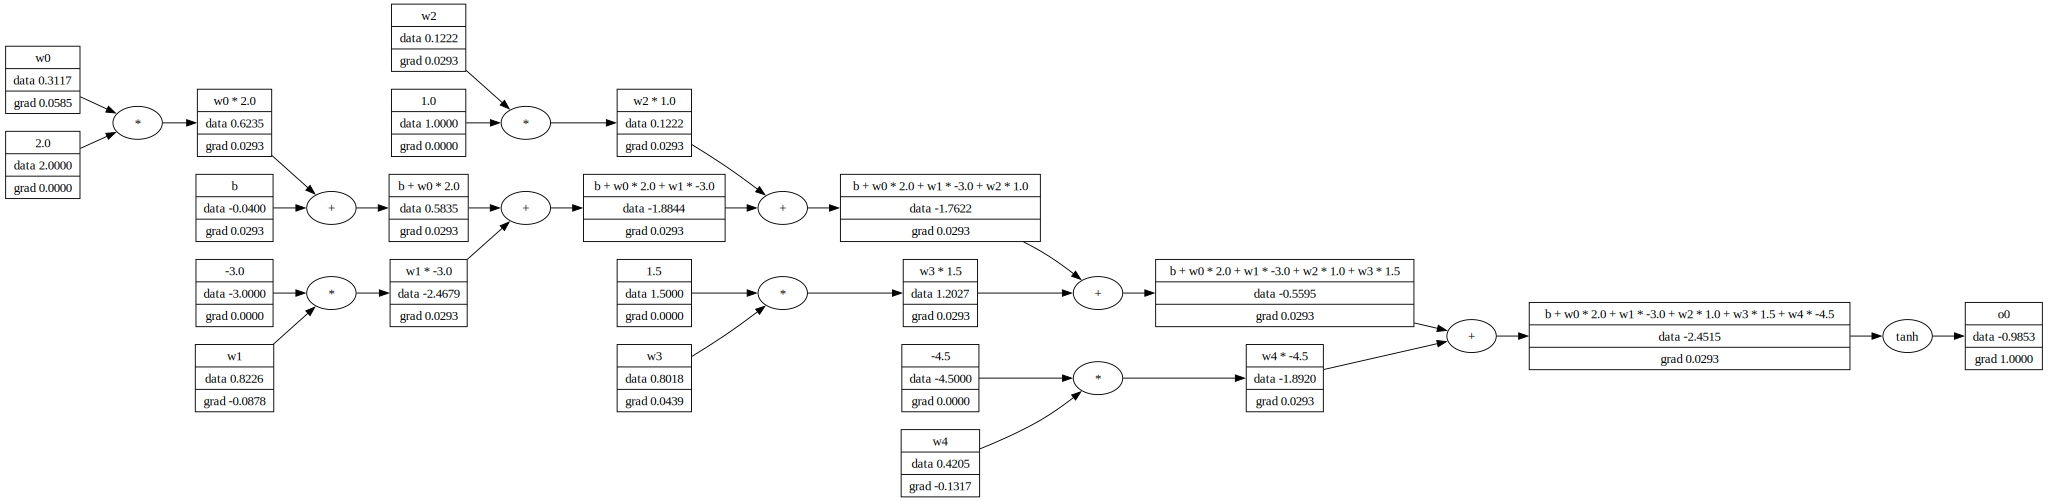

In [39]:
outs[0].backward()
draw_dot(outs[0])

### Test complete NN

In [54]:
nn = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
res = nn(x)
res.backward()
print(res)

Value(data=-0.395795221688051)


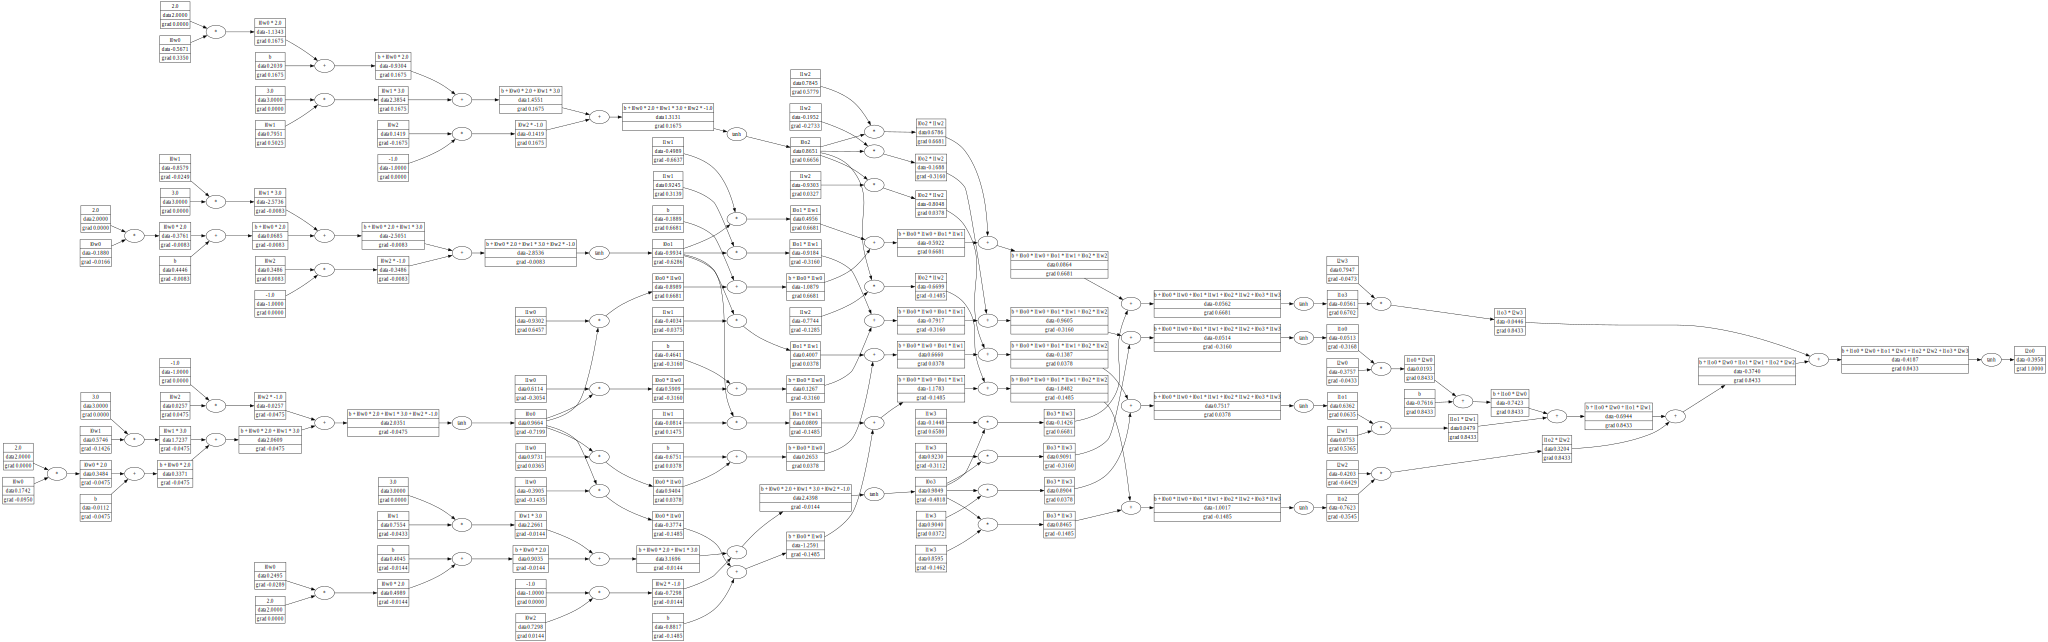

In [55]:
draw_dot(res)

### Training NN with Mean Squared Loss

In [56]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [142]:
# Define NN
np.random.seed(42)
nn = MLP(3, [4, 4, 1])

In [ ]:
# TRAINING LOOP!
num_iters = 100
learning_rate = 0.01
beta = 0.2
for _ in range(num_iters):
    y_preds = [nn(x) for x in xs]
    y_preds
    loss = sum((y - y_pred)**2 for y, y_pred in zip(ys, y_preds))
    loss.label = 'MSE'
    # print(loss)

    # Do backward pass
    loss.backward()

    # Adjust weights using grads and then reset grads
    params = nn.parameters()
    for param in params:
        param.data = param.data + learning_rate * (-param.grad)
        param.grad = beta * param.grad # Can this be called momentum?

# Print final loss
y_preds = [nn(x) for x in xs]
y_preds
loss = sum((y - y_pred)**2 for y, y_pred in zip(ys, y_preds))
loss.label = 'MSE'
print(loss)

Value(data=0.02761244090408208)


In [146]:
y_preds

[Value(data=0.9030044660027658),
 Value(data=-0.9267218842916884),
 Value(data=-0.914345176525372),
 Value(data=0.9258523347471879)]